In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from ns_f import *

Create global classes:
- **data**: Predefinded list of fixed size that tracks all packages in the network. This class is shared among all elements of the network and has a fixed size. Packets that leave the network (reach the destination) are deleted from data and make space for new packets. 
- **global_ident**: This class is also shared among all elements of the network and can be used to create a unique identifier for new packages.

In [2]:
dat = data(packet_list_size=1000)
ident = global_ident()

Let's quickly check the (first three elements of) dat table:

In [3]:
dat.package_list.head(3)

,ident,circuit,ts,tr
0,NaN,NaN,inf,inf
1,NaN,NaN,inf,inf
2,NaN,NaN,inf,inf


Note again that the table is blank. There are no packages in the network just yet.
Later the current status of each package is tracked with lists of indices refering to this table. **This is a very important concept**: Whenever a packet is in a buffer, in transit or processed, lists of indices are read, copied, altered or stored.

Create a setup dict for all the servers (nodes) that are created. For the test, all servers will have the same properties.
- **v_max**: Maximum number of packets that can be send per second
- **s_max**: Maximum number of packets that can be (combined) in all the input/output buffers of the server
- **timeout**: time duration after which a sent packet is considered 'lost'. Timeout will trigger to adjust the window size.

In [4]:
setup_dict = {}
setup_dict['v_max'] = 1000   # packets / s
setup_dict['s_max'] = 30     # packets
setup_dict['timeout'] = 1    # s

Lets create some objects:

In [5]:
input_1  = server(setup_dict, ident, dat, name='input_1' )
input_2  = server(setup_dict, ident, dat, name='input_2' )
output_1 = server(setup_dict, ident, dat, name='output_1')
output_2 = server(setup_dict, ident, dat, name='output_2')
server_1 = server(setup_dict, ident, dat, name='server_1')
server_2 = server(setup_dict, ident, dat, name='server_2')

And define the routes of two circuits through the network:

In [6]:
circuits = [
    {'route': [input_1, server_1, server_2, output_1]},
    {'route': [input_2, server_1, server_2, output_2]},
]

Finally we create the network class, which needs only the data object from above for its "__init__". We can optionally define the timestep and initial time (in seconds):

In [7]:
nw = network(data=dat, t0=0, dt=0.01)

The first method we invoke is .from_circuits. This will create a table of nodes and connections and determine some relevant properties:

In [8]:
nw.from_circuits(circuits)

If graph_tool is available, we can quickly visualize the network. The important objects: **connections** and **nodes** will be discussed below.

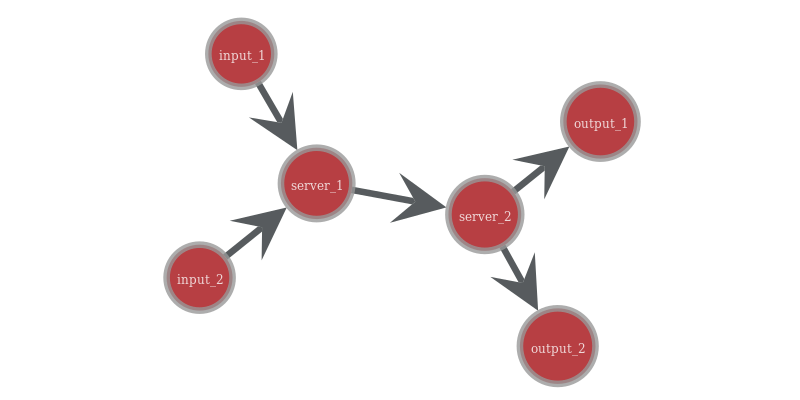

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fc8b690c0f0, at 0x7fc8b690c128>

In [49]:
import graph_tool.all as gt
edge_list, node_list = nw.connections, nw.nodes

# Create Graph and populate with edges and vertices:
g = gt.Graph()
vert_prop = {}
vert_prop['text'] = g.new_vertex_property('string')

node_list['vert'] = None
for i, node_i in node_list.iterrows():
    node_list['vert'][i] = g.add_vertex()
    vert_prop['text'][node_list['vert'][i]] = node_i['name']
# Add an edge to the graph for every connection and 
# save it with the respective 'source' and 'target' objects:
edge_list['edge'] = None
for i, edge_i in edge_list.iterrows():
    source_i = node_list[node_list['node'] == edge_i['source']]
    target_i = node_list[node_list['node'] == edge_i['target']]
    edge_list['edge'][i] = g.add_edge(source_i.vert.values[0], target_i.vert.values[0])
    
pos = gt.sfdp_layout(g, K=0.5)
gt.graph_draw(g, pos=pos, vprops=vert_prop, output_size=[800,400])

Lets investigate these objects. First the nodes:

In [9]:
nw.nodes

,node,name,con_target,n_in,con_source,n_out,output_circuits
0,<ns_f.server object at 0x7fc8cefabef0>,input_1,"[False, False, False, False, False]",0,"[True, False, False, False, False]",1,[[0]]
1,<ns_f.server object at 0x7fc8cefabb70>,server_1,"[True, False, False, True, False]",2,"[False, True, False, False, False]",1,"[[0, 1]]"
2,<ns_f.server object at 0x7fc8cefabeb8>,server_2,"[False, True, False, False, False]",1,"[False, False, True, False, True]",2,"[[0], [1]]"
3,<ns_f.server object at 0x7fc8cefabcf8>,output_1,"[False, False, True, False, False]",1,"[False, False, False, False, False]",0,None
4,<ns_f.server object at 0x7fc8cefab208>,input_2,"[False, False, False, False, False]",0,"[False, False, False, True, False]",1,[[1]]
5,<ns_f.server object at 0x7fc8cefabdd8>,output_2,"[False, False, False, False, True]",1,"[False, False, False, False, False]",0,None


- **node** / name: Reference to one of the server objects that were created above.
- **n_in**: Number of inputs
- **n_out**: Number of output

- **con_source**: For which connections is the current node the source (Note that this boolean array has the same number of elements as the number of connections).
- **con_target**: Similarly, for which connections the current node is the target
- **output_circuits**: A list item for each output_buffer that contains the circuits that are in this buffer

Now the connections:

In [10]:
nw.connections

,source,target,circuit,source_name,target_name,feat,source_ind,target_ind
0,<ns_f.server object at 0x7fc8cefabef0>,<ns_f.server object at 0x7fc8cefabb70>,[0],input_1,server_1,<ns_f.connection object at 0x7fc8cefb8668>,0,0
1,<ns_f.server object at 0x7fc8cefabb70>,<ns_f.server object at 0x7fc8cefabeb8>,"[0, 1]",server_1,server_2,<ns_f.connection object at 0x7fc8cefb8588>,0,0
2,<ns_f.server object at 0x7fc8cefabeb8>,<ns_f.server object at 0x7fc8cefabcf8>,[0],server_2,output_1,<ns_f.connection object at 0x7fc8cefb80f0>,0,0
3,<ns_f.server object at 0x7fc8cefab208>,<ns_f.server object at 0x7fc8cefabb70>,[1],input_2,server_1,<ns_f.connection object at 0x7fc8cefb8080>,0,1
4,<ns_f.server object at 0x7fc8cefabeb8>,<ns_f.server object at 0x7fc8cefabdd8>,[1],server_2,output_2,<ns_f.connection object at 0x7fc8cefb8438>,1,0


Where **source** and **target** are again referencing server objects (with their respective name) and **circuit** is a list of all circuits that are carried in this connections. **source_ind** and **target_ind** are very important: Each server has as many output buffer as the number of outgoing connections. These are stored as a list. To find the relevant output_buffer of the source for the current connection, the **source_ind** has to be used as index as in: source.output_buffer[source_ind].

The **feat** (features) objects are further attributes of the connections and are shown below for connection 1:

In [11]:
nw.connections.loc[1,'feat'].__dict__

{'latency_fun': <function ns_f.connection.<lambda>(t)>,
 'window_size': 2,
 'transit_size': 0,
 'transit': [],
 'window': [],
 'transit_reply': []}

Now that everything is set up, we can add some intial packages to the inputs and run a couple of simulation steps. First the initial packages:

In [12]:
input_1.add_2_buffer(buffer_ind=0, circuit=0, n_packets=10)
input_2.add_2_buffer(buffer_ind=0, circuit=1, n_packets=10)

As we can see, the data object is now populated:

In [51]:
dat.package_list.head(4)

,ident,circuit,ts,tr
0,0,0,0.000000,inf
1,1,0,0.000000,inf
2,2,0,inf,inf
3,3,0,inf,inf


The simulation of one timestep is invoked with .simulate():

In [50]:
nw.simulate()

What has happened now? Simulate is a list of operations that are executed for each connection.
```python
for i, con in self.connections.iterrows()
    ...
```
### 1. Check timeout
Check if any packages of the previous congestion window reached a "timeout". This is not relevant in the first step as the window is still empty.

### 2. Send packages
Populate the window, if it is empty.
1. We determine the packages that will be send, by
   - Checking the respective buffer of the source of the current connection with 
   ```python 
   source_buffer = con.source.output_buffer[con.source_ind]
   ```
   - Determine how many many packages will be sent:
   ```python 
   n_send = min(con.window_size, len(source_buffer), int(con.source.v_max*dt))
   ```
   Where the number of packets cant exceeed the allowed window size, we can't send more than we have and also there is a limit to the number of packets we can sent per time. The packets that are supposed to be sent in the current window but violate the last condition are therefore sent in the following timestep.
   
2. We send the packages by adding the indices that refer to the package_list in 'data' to:
   - 
   ```python 
   con.feat.window  += send_ind
   ```
   - 
   ```python 
   con.feat.transit += send_ind
   ```

3. We update the time in the package_list in 'data' for the packets that have been sent.
   ```python 
   self.data.package_list.loc[send_ind, 'ts'] = self.t
   ```
   Where 'ts' stands for time sent.
   
Let's quickly check the respective lists for the connection from input_1 to server_1:

In [56]:
print('nw.connections.loc[0].feat.window = {}'.format(nw.connections.loc[0].feat.window))
print('nw.connections.loc[0].feat.transit = {}'.format(nw.connections.loc[0].feat.transit))
dat.package_list.head(2)

nw.connections.loc[0].feat.window = [0, 1]
nw.connections.loc[0].feat.transit = [0, 1]


,ident,circuit,ts,tr
0,0,0,0.0,inf
1,1,0,0.0,inf
